In [210]:
import gym
import numpy as np
import random

In [22]:
import torch

In [356]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [409]:
a = [1] * 50
coeff = 1
for i in range(len(a) - 40, len(a)):
    a[i] = a[i] * coeff
    coeff = coeff * 0.9
print(a)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9, 0.81, 0.7290000000000001, 0.6561000000000001, 0.5904900000000002, 0.5314410000000002, 0.47829690000000014, 0.43046721000000016, 0.38742048900000015, 0.34867844010000015, 0.31381059609000017, 0.28242953648100017, 0.25418658283290013, 0.22876792454961012, 0.2058911320946491, 0.1853020188851842, 0.16677181699666577, 0.1500946352969992, 0.13508517176729928, 0.12157665459056936, 0.10941898913151243, 0.0984770902183612, 0.08862938119652508, 0.07976644307687257, 0.07178979876918531, 0.06461081889226679, 0.05814973700304011, 0.0523347633027361, 0.04710128697246249, 0.042391158275216244, 0.03815204244769462, 0.03433683820292516, 0.030903154382632643, 0.02781283894436938, 0.025031555049932444, 0.0225283995449392, 0.020275559590445278, 0.01824800363140075, 0.016423203268260675]


In [464]:
class Memory():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.short_memory = []
        
    def push(self, obs, action):
        self.short_memory.append([obs, action, 1 - abs(obs[0])/5.0])
        
    def commit(self, final_reward):
#         for i in range(len(self.short_memory)):
#             self.short_memory[i][2] = final_reward
        coeff = 1
        for i in range(len(self.short_memory) - 20, len(self.short_memory)):
            if i < 0: continue
            self.short_memory[i][2] = self.short_memory[i][2] * coeff
            coeff *= 0.9
            
        if len(self.memory) + len(self.short_memory) < self.capacity:
            self.memory.extend(self.short_memory)
            self.short_memory = []
        else:
            for memo in self.short_memory:
                if random.random() > 0.5:
                    self.memory.insert(0, memo)
                else:
                    self.memory[random.randint(0, self.capacity-1)] = memo
            self.short_memory = []

In [465]:
class My_module(torch.nn.Module):
    def __init__(self, device):
        super(My_module, self).__init__()
        self._device = device
        
    def forward(self, x):
        return x - torch.FloatTensor([0.5]).to(self._device)


model = torch.nn.Sequential(
    torch.nn.Linear(4, 32),
    torch.nn.LeakyReLU(inplace=True),
#     torch.nn.Linear(32, 32),
#     torch.nn.LeakyReLU(inplace=True),
    torch.nn.Linear(32, 2),
    torch.nn.Sigmoid(),
    torch.nn.Softmax(dim=1),
)

model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.1)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=50, gamma=0.9)

In [466]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 1000

STEP = 0
EPS = 0.9
EPS_MIN = 0.02
GAMMA = 0.9999


def get_model_action(model, observation, device, train=True):
    global STEP, EPS, EPS_MIN, GAMMA
    STEP += 1
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
    if not train or random.random() > EPS:
        with torch.no_grad():
            model_output = model(torch.FloatTensor(obs).to(device).unsqueeze(0)).cpu().detach().numpy()
            action = np.argmax(model_output)
    else:
        action = random.randint(0, 1)
    return action

def train(model, memory, device):
    memory = memory.memory

    train_data = []
    for memo in memory:
        obs, action, reward = memo
        if action == 0:
            action = [reward, 1-reward]
        else:
            action = [1-reward, reward]
        train_data.append([obs, action])
        
    batch_size = 1024
    np.random.shuffle(train_data)
    
    for i in range((len(train_data) // batch_size)):
        model.zero_grad()
        
        data = train_data[i*batch_size : i*batch_size + batch_size]
        x, y = [x[0] for x in data], [x[1] for x in data]
        output = model(torch.FloatTensor(x).to(device))
        loss = torch.nn.functional.l1_loss(output, torch.FloatTensor(y).to(device))
        loss.backward()
        optim.step()
        
    scheduler.step()

memory = Memory()

#get starting actions
for episode in range(2000):
    obs = env.reset()
    for i in range(100):
        action = env.action_space.sample()
        memory.push(obs, action)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break
    memory.commit(i)
        

from itertools import count

len_mem = []
try:
    for episode in range(1000):
        obs = env.reset()

        for i in count():
#             env.render()

            action = get_model_action(model, obs, device)
            memory.push(obs, action)
            obs, reward, done, info = env.step(action)

            if done:
                env.close()
                len_mem.append(i)
                memory.commit(i)
                break

        
        if episode % 10 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(len_mem[-10:]), EPS))

        
        
        train(model, memory, device)
    
except KeyboardInterrupt:
    env.close()

Episode   0:     53.000 iterations, eps=0.895153
Episode  10:     21.900 iterations, eps=0.874886
Episode  20:     54.900 iterations, eps=0.827319
Episode  30:     35.400 iterations, eps=0.797745
Episode  40:     46.700 iterations, eps=0.760584
Episode  50:     39.500 iterations, eps=0.730394
Episode  60:     70.500 iterations, eps=0.679992
Episode  70:     98.400 iterations, eps=0.615648
Episode  80:    162.100 iterations, eps=0.522993
Episode  90:    160.000 iterations, eps=0.445216
Episode 100:    256.400 iterations, eps=0.344174
Episode 110:    491.500 iterations, eps=0.210318
Episode 120:    418.200 iterations, eps=0.138297
Episode 130:    570.900 iterations, eps=0.078060
Episode 140:    682.400 iterations, eps=0.039411
Episode 150:    912.500 iterations, eps=0.020000
Episode 160:    816.600 iterations, eps=0.020000
Episode 170:    759.300 iterations, eps=0.020000
Episode 180:    855.700 iterations, eps=0.020000
Episode 190:    844.500 iterations, eps=0.020000
Episode 200:    740.

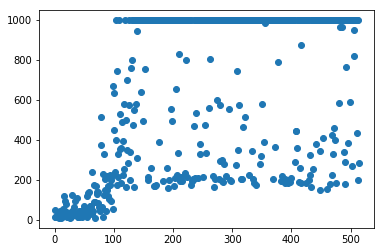

In [467]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(len_mem, 'o')

In [477]:
try:
    env.reset()
    env._max_episode_steps = 5000
    for t in count():
        env.render()
        action = get_model_action(model, obs, device, train=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break

    print(t)
finally:
    env.close()
    print(t)

225


KeyboardInterrupt: 

In [351]:
env.close()

In [470]:
model.to('cpu')

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=32, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)

In [471]:
torch.save(model, 'model.torch')

In [474]:
model = torch.load('model.torch')

In [475]:
model.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=32, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)